In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# faz a leitura do ficheiro de dados localizado no github

url = 'https://raw.githubusercontent.com/Miguel-Salgado/covid-19/master/obitos-e-casos-confirmados-de-cov.csv'
df = pd.read_csv(url,error_bad_lines=False)
# df = df[(df.T != 0).all()]
df.head(50)


,Dia,Confirmados,Obitos
0,60,0,0
1,61,2,0
2,62,4,0
3,63,6,0
4,64,9,0
5,65,13,0
6,66,21,0
7,67,30,0
8,68,39,0
9,69,41,0


In [69]:
# define a função logística usada no modelo

def logistic_model(x,a,b,c):
    return c/(np.exp((b-x)/a)+1)

def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def log_logistic_model(x,a,b,c):
    return c/(1+np.power((x/a),-b))



In [74]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,2])

# print(x,y)

# utiliza curve_fit para fazer o ajuste dos dados, calculando os parâmetros a,b,c

logistic_fit = curve_fit(logistic_model,x,y,p0=[5,100,1000])

#exp_fit = curve_fit(exponential_model,x,y,p0=[577,0,104])

log_logistic_fit = curve_fit(log_logistic_model,x,y,p0=[100,10,900],bounds=(0, [999., 999., 999.]))

param_a_logistic = logistic_fit[0][0]
param_b_logistic = logistic_fit[0][1]
param_c_logistic = logistic_fit[0][2]

#param_a_exp = exp_fit[0][0]
#param_b_exp = exp_fit[0][1]
#param_c_exp = exp_fit[0][2]

param_a_log_logistic = log_logistic_fit[0][0]
param_b_log_logistic = log_logistic_fit[0][1]
param_c_log_logistic = log_logistic_fit[0][2]

print("Logistic model: a = % 5.2f; b = % 5.2f; c = % 5.2f" %(param_a_logistic, param_b_logistic, param_c_logistic))
#print("Exponential model: a = % 5.2f; b = % 5.2f; c = % 5.2f" %(param_a_exp, param_b_exp, param_c_exp))
print("Log-Logistic model: a = % 5.2f; b = % 5.2f; c = % 5.2f" %(param_a_log_logistic, param_b_log_logistic, param_c_log_logistic))


Logistic model: a =  5.54; b =  97.88; c =  760.68
Log-Logistic model: a =  98.77; b =  16.08; c =  818.98


In [76]:
# calcula o erro associado ao ajuste efetuado 

errors_logistic = [np.sqrt(fit_logistic[1][i][i]) for i in [0,1,2]]

y_pred_logistic = [logistic_model(i,param_a_logistic,param_b_logistic,param_c_logistic) for i in x]

#y_pred_exponential = [exponential_model(i,param_a_exp,param_b_exp,param_c_exp) for i in x]

errors_log_logistic = [np.sqrt(log_logistic_fit[1][i][i]) for i in [0,1,2]]

y_pred_log_logistic = [log_logistic_model(i,param_a_log_logistic,param_b_log_logistic,param_c_log_logistic) for i in x]



In [82]:
# calcula a data final da infeção resolvendo a equação associada ao modelo

sol_logistic = int(fsolve(lambda x : logistic_model(x,param_a_logistic,param_b_logistic,param_c_logistic) - int(param_c_logistic),param_b_logistic))
end_date_logistic = datetime(2020, 1, 1) + timedelta(days=sol_logistic)

                              

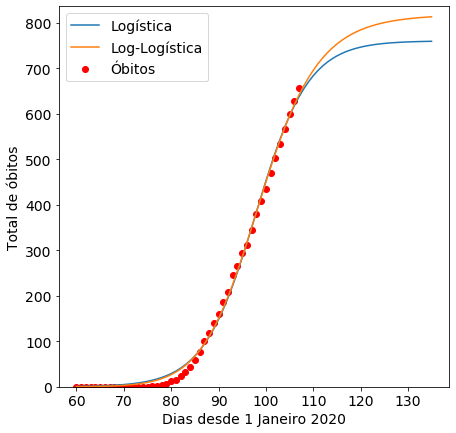

Previsão de óbitos para amanhã: 655 (modelo logístico)
Previsão de óbitos para amanhã: 661 (modelo log-logístico)
Previsão do número total de óbitos: 760 +/- 21 (modelo logístico)
Previsão do número total de óbitos: 818 +/- 25 (modelo log-logístico)
Previsão do final da infeção: 16/5/2020 (modelo logístico)
Erro quadrado médio do ajuste: 130 (modelo logístico)
Erro quadrado médio do ajuste: 95 (modelo log-logístico)


In [87]:
# constrói o gráfico e mostra os resultados das predições

pred_x = list(range(max(x),sol_logistic))

plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
plt.scatter(x,y,label="Óbitos",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,param_a_logistic,param_b_logistic,param_c_logistic) for i in x+pred_x], label="Logística" )

# Predicted log-logistic curve
plt.plot(x+pred_x, [log_logistic_model(i,param_a_log_logistic,param_b_log_logistic,param_c_log_logistic) for i in x+pred_x], label="Log-Logística" )

# Predicted exponential curve
#plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponencial" )

plt.legend()
plt.xlabel("Dias desde 1 Janeiro 2020")
plt.ylabel("Total de óbitos")
plt.ylim((min(y)*0.9,param_c*1.1))
plt.show()

# print previsões
print("Previsão de óbitos para amanhã: %d (modelo logístico)" %(logistic_model(max(x)+1,param_a_logistic,param_b_logistic,param_c_logistic)))
print("Previsão de óbitos para amanhã: %d (modelo log-logístico)" %(log_logistic_model(max(x)+1,param_a_log_logistic,param_b_log_logistic,param_c_log_logistic)))
print("Previsão do número total de óbitos: %2d +/- %2d (modelo logístico)" %(param_c_logistic, errors_logistic[2]))
print("Previsão do número total de óbitos: %2d +/- %2d (modelo log-logístico)" %(param_c_log_logistic, errors_log_logistic[2]))
print("Previsão do final da infeção: %d/%d/%d (modelo logístico)" %(end_date_logistic.day, end_date_logistic.month, end_date_logistic.year))
print("Erro quadrado médio do ajuste: %1d (modelo logístico)" %mean_squared_error(y,y_pred_logistic))
print("Erro quadrado médio do ajuste: %1d (modelo log-logístico)" %mean_squared_error(y,y_pred_log_logistic))
